# COVID

2019 Novel Coronavirus (2019-nCoV) is a virus (more specifically, a coronavirus) identified as the cause of an outbreak of respiratory illness first detected in Wuhan, China. Early on, many of the patients in the outbreak in Wuhan, China reportedly had some link to a large seafood and animal market, suggesting animal-to-person spread. However, a growing number of patients reportedly have not had exposure to animal markets, indicating person-to-person spread is occurring. At this time, it’s unclear how easily or sustainably this virus is spreading between people - CDC

This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. Please note that this is a time series data and so the number of cases on any given day is the cumulative number.

The data is available from 22 Jan, 2020.

In [3]:
pip install pmdarima

     |████████████████████████████████| 604kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 7.2MB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 28.5MB 2.7MB/s eta 0:00:01     |█████████████████▌              | 15.6MB 3.1MB/s eta 0:00:05
     |████████████████████████████████| 8.4MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 15.2MB 3.0MB/s eta 0:00:01
ERROR: keras 2.2.4 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
ERROR: keras 2.2.4 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
  Found existing installation: numpy 1.16.5
    Uninstalling numpy-1.16.5:
      Successfully uninstalled numpy-1.16.5
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully unins

In [4]:
# import libraries
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import the dataset from Kaggle, located here: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper

df = pd.read_csv('covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
df.shape

(7926, 8)

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

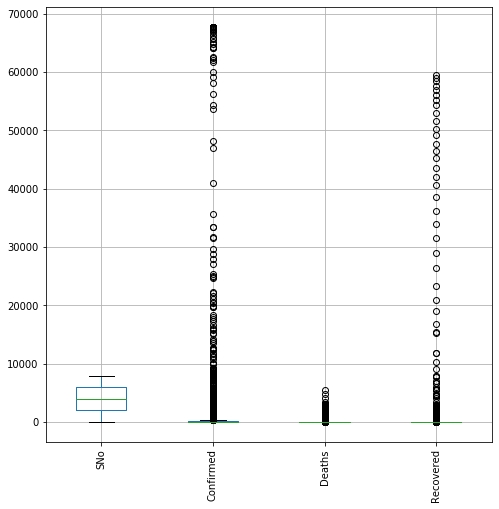

In [8]:
pd.DataFrame.boxplot(df,figsize=(8,8))
plt.xticks(rotation=90)

In [9]:
confirmed = df['Confirmed']

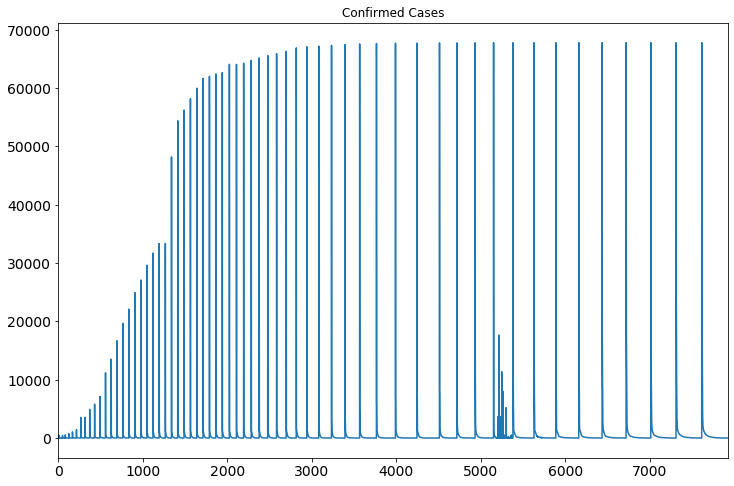

In [13]:
confirmed.plot(figsize=(12,8), title= 'Confirmed Cases', fontsize=14)
# plt.savefig('confirmed'.png', bbox_inches='tight')

In [ ]:
Hyperparameter Tuning

In [ ]:
X = df.drop(['Attrition'],axis=1)
y = df['Attrition']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X.corrwith(df['Attrition']).plot.bar(figsize = (20, 10), title ="Correlation with Attrition", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())